### Buy and Hold
1. 구매 후 일정 기간이 지나면 판매

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df = pd.read_csv('../../csv/AAPL.csv', index_col='Date')
df.head(1)

In [ ]:
# 결측치와 무한대 값들이 존재하는가?
df.isin([np.nan, np.inf, -np.inf]).any(axis=0)

In [ ]:
df.loc[:, (df.isin([np.nan, np.inf, -np.inf]).any(axis=0))]

In [ ]:
# 결측치와 무한대의 값을 제외한 데이터
df = df.loc[~(df.isin([np.nan, np.inf, -np.inf]).any(axis=1))]

In [ ]:
# 수정종가를 기준으로 구매와 판매를 하여 수익율 계산
price_df = df[['Adj Close']]

In [ ]:
price_df.plot()

In [ ]:
# 일별 수익율
# (오늘의 종가 - 전날의 종가) / 전날의 종가
# case1
(price_df['Adj Close'] - price_df['Adj Close'].shift(1)) \
    / price_df['Adj Close'].shift(1)
# case2
price_df['Adj Close'].diff() / price_df['Adj Close'].shift()
# case3 
price_df['daily_rtn'] = price_df['Adj Close'].pct_change()

In [ ]:
price_df.head(4)

In [ ]:
test_df = price_df.iloc[6000:8000]

In [ ]:
# 수익율 계산
test_df.iloc[-1, 0] / test_df.iloc[0, 0]

In [ ]:
# 일별 수익율 가지고 수익율 계산

# 초기 수익율 1로 지정
rtn = 1

# (일별 수익율 + 1) * rtn -> 수익율
for i in range(len(test_df)):
    # i는 인덱스의 위치값
    # rtn = (test_df.iloc[i, 1] + 1) * rtn
    rtn *= (test_df.iloc[i, 1] + 1)
print(rtn)

In [ ]:
# 누적곱을 구하는 함수
test_df['st_rtn'] = (1 + test_df['daily_rtn']).cumprod()

<AxesSubplot: xlabel='Date'>

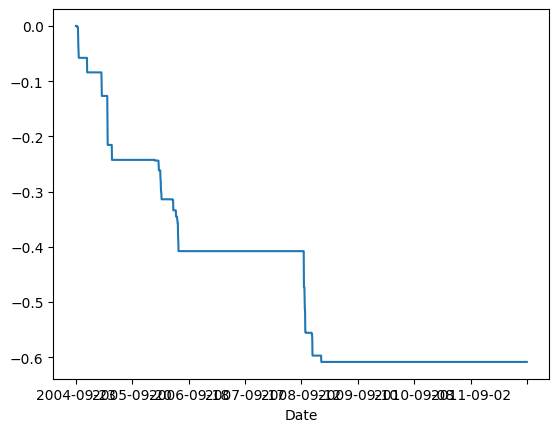

In [31]:
# back testing 

# 최대낙폭

# 기준 값에서 최고가를 저장
historical_max = test_df['Adj Close'].cummax()
daily_drawdown = test_df['Adj Close'] / historical_max - 1.0

historical_min = daily_drawdown.cummin()
historical_min.plot()

In [32]:
# CAGR, MDD, VOL, sharpe 출력
# CAGR : 일별 date 사용 -> 
# 전체 연도를 계산하는 경우에는 영업일 기간을 252일 기준으로 나눈 역수 제곱한 후 -1
# MDD : 최대 낙폭
# VOL : 연 주가 수익율 표준편차 = 일별 주가 수익율 * 252일 제곱근
# sharpe : 총 위험 1단위당 초과 수익율
CAGR = test_df.iloc[-1, 2] ** (252/len(test_df)) - 1
MDD = historical_min.min()
VOL = np.std(test_df['daily_rtn']) * np.sqrt(252)
sharpe = np.mean(test_df['daily_rtn']) \
    / np.std(test_df['daily_rtn'])*np.sqrt(252)

In [33]:
print('CAGR :', round(CAGR*100, 2), '%')
print('Sharpe :', round(sharpe, 2))
print('VOL :', round(VOL*100, 2), '%')
print('MDD :', round(-1*MDD*100, 2), '%')

CAGR : 57.42 %
Sharpe : 1.38
VOL : 38.04 %
MDD : 60.87 %


## Buy and Hold 함수화
1. 매개변수 1개(데이터프레임)
2. 결측치, 무한대의 값을 제거 
3. 수정종가만 있는 데이터프레임으로 변경
4. 일별 수익율 파생변수 생성
5. 누적 수익율 파생변수 생성
6. 데이터프레임 리턴

In [67]:
def buyandhold(df, col = 'Close' , start = '20100101', end = "20230818"):
    # 인덱스가 Date인가?
    # 인덱스가 Date가 아니면 Date를 인덱스로 변경
    if 'Date' in df.columns:
        # 컬럼에 Date가 포함되어있으면 Date를 인덱스로 변경
        df = df.set_index('Date')
    # 인덱스를 시계열 데이터 변경
    df.index = pd.to_datetime(df.index, format='%Y-%m-%d')
    # 수정 종가만으로 이루어진 데이터프레임으로 변경
    df = df[[col]]
    # start, end로 인덱스 필터링
    start = datetime.strptime(start, '%Y%m%d').isoformat()
    end = datetime.strptime(end, '%Y%m%d').isoformat()
    df = df.loc[start:end]
    # 결측치, 무한대의 값을 제거 
    # 인덱스의 조건식
    flag = ~df.isin([np.nan, np.inf, -np.inf]).any(axis=1)
    df = df.loc[flag]
    # 일별 수익율 파생변수 생성
    df['daily_rtn'] = df[col].pct_change()
    # 누적 수익율 파생변수 생성
    df['st_rtn'] = (1 + df['daily_rtn']).cumprod()
    # 데이터프레임을 리턴
    return df

In [60]:
df2 = pd.read_csv("../../csv/AMZN.csv", index_col = 'Date')

In [61]:
buyandhold(df2, '20100101', '20151231')

,Adj Close,daily_rtn,st_rtn
Date,,,
2010-01-04,133.899994,NaN,NaN
2010-01-05,134.690002,0.005900,1.005900
2010-01-06,132.250000,-0.018116,0.987677
2010-01-07,130.000000,-0.017013,0.970874
2010-01-08,133.520004,0.027077,0.997162
...,...,...,...
2015-12-24,662.789978,-0.001371,4.949888
2015-12-28,675.200012,0.018724,5.042569
2015-12-29,693.969971,0.027799,5.182748


In [44]:
# index를 시계열 데이터로 변경
df2.index = pd.to_datetime(df2.index, format="%Y-%m-%d")

In [ ]:
df2.index

In [46]:
from datetime import datetime

In [51]:
a = '20100101'
b = '20121231'
start = datetime.strptime(a, '%Y%m%d').isoformat()
end = datetime.strptime(b, '%Y%m%d').isoformat()

In [ ]:
df2.loc[start:end]

In [62]:
df3 = pd.read_csv('../../csv/BND.csv')

In [58]:
df3.head(1)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2007-04-10,75.07,75.260002,75.0,75.239998,51.523693,35000


In [65]:
buyandhold(df3, '20100101', '20150101')

,Adj Close,daily_rtn,st_rtn
Date,,,
2010-01-04,60.611969,NaN,NaN
2010-01-05,60.789135,0.002923,1.002923
2010-01-06,60.766037,-0.000380,1.002542
2010-01-07,60.719822,-0.000761,1.001779
2010-01-08,60.781410,0.001014,1.002796
...,...,...,...
2014-12-24,73.073853,0.000366,1.205601
2014-12-26,73.136253,0.000854,1.206631
2014-12-29,73.260918,0.001705,1.208687
